In [1]:
import autoencoders.images_from_text as ift
reload(ift)
import os
import PIL
import PIL.Image
import PIL.ImageFont
import PIL.ImageOps
import PIL.ImageDraw
from keras.preprocessing.image import img_to_array, array_to_img

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN not available)


In [17]:

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

img_width = 28
img_height = 28
font_size = 4
batch_size = 20
original_dim = img_width * img_height
latent_dim = 2
another_dim = 1024
intermediate_dim = 256
nb_epoch = 2

x = Input(batch_shape=(batch_size, original_dim))
x1 = Dense(another_dim, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(x1)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (20, 784)             0                                            
____________________________________________________________________________________________________
dense_16 (Dense)                 (20, 256)             200960      input_6[0][0]                    
____________________________________________________________________________________________________
dense_17 (Dense)                 (20, 2)               514         dense_16[0][0]                   
____________________________________________________________________________________________________
dense_18 (Dense)                 (20, 2)               514         dense_16[0][0]                   
___________________________________________________________________________________________

In [18]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_train = x_train[:6000, :]
x_test = x_test[:2000, :]
x_test.shape, x_train.shape

x_train.shape, x_test.shape

((6000, 784), (2000, 784))

In [3]:
test = ift.train_set_from_dir('data/hadoop_images/test')
x_train = test[:20000, :].astype('float32') / 255.
x_test = test[-4600:, :].astype('float32') / 255.
x_train.shape, x_test.shape

((20000, 40000), (4600, 40000))

In [19]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Train on 6000 samples, validate on 2000 samples
Epoch 1/1
6000/6000 [==============================] - 3s - loss: 213.1761 - val_loss: 180.6523


In [20]:
encoder = Model(x, z_mean)

decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
new_img_generator = Model(decoder_input, _x_decoded_mean)

-20 -20


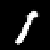

-20 -10


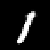

-20 0


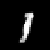

-20 10


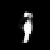

-10 -20


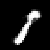

-10 -10


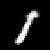

-10 0


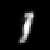

-10 10


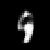

0 -20


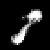

0 -10


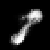

0 0


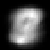

0 10


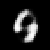

10 -20


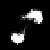

10 -10


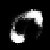

10 0


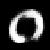

10 10


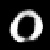

In [21]:

from IPython.display import display
for a in range(-20, 20, 10):
    for b in range(-20, 20, 10):
        ara = new_img_generator.predict(np.array([[a,b]]))
        ima = array_to_img(ara.reshape((1, img_width, img_height))).resize((50, 50))
        print a, b
        display(ima)